In [1]:
# If this cell does not work try running `pip install nbformat`

import io
from IPython import nbformat

nb = nbformat.read("Lab1-2021.ipynb", nbformat.NO_CONVERT)
word_count = 0
for cell in nb.cells:
    if cell.cell_type == "markdown":
        word_count += len(cell['source'].replace('#', '').lstrip().split(' '))

print("Word count:", word_count)

Word count: 909


D:\anaconda\lib\site-packages\IPython\nbformat.py:12: ShimWarning: The `IPython.nbformat` package has been deprecated since IPython 4.0. You should import from nbformat instead.
  warn("The `IPython.nbformat` package has been deprecated since IPython 4.0. "


# CS4035 - Cyber Data Analytics
## Lab 1 - Fraud data

## Group Number : 29

## Student 1 
### Name : Mingyu Gao
### ID : 5216281

## Student 2
### Name : Yuhang Tian
### ID : 5219728

## Readme
The libraries we installed include three types:
- basic data process: numpy==1.19.2, pandas==1.1.3, ipython==7.22.0
- machine learning: scikit_learn==0.24.2, imblearn==0.0
- visualization: matplotlib==3.3.2, seaborn==0.11.0, jupyterthemes==0.20.0

Readers can get the same dependencies as ours with the command - pip install -r requirements.txt. 

## Load Library

In [2]:
from jupyterthemes import jtplot
import numpy as np
import pandas as pd

import random

import matplotlib.pyplot as plt
from matplotlib_venn import venn2 
import seaborn as sns

from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import LabelEncoder, Normalizer
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, roc_auc_score, plot_confusion_matrix, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

jtplot.style('grade3')

## Read Data
Before we execute this assignment, we have a brief look at the original data. We print the amount and percentage of three types of transaction.

In [3]:
# #Step 1: Loading the raw data file into our initial dataframe - df 
df = pd.read_csv('./data_for_student_case.csv')
df.head()

,txid,bookingdate,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,simple_journal,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id
0,1,2015-11-09 14:26:51,MX,mccredit,530056.0,64800.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-01 23:03:11,MexicoAccount,email68370,ip111778,card184798
1,2,2015-11-09 14:27:38,MX,mccredit,547046.0,44900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 04:50:55,MexicoAccount,email101299,ip78749,card151595
2,3,2015-11-23 16:34:16,MX,mccredit,528843.0,149900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-02 14:30:28,MexicoAccount,email278604,ip70594,card242142
3,4,2015-11-23 16:34:51,MX,mccredit,547146.0,109900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-03 07:53:37,MexicoAccount,email47409,ip113648,card181744
4,5,2015-11-09 14:26:08,MX,visaclassic,477291.0,89900.0,MXN,MX,Ecommerce,Chargeback,True,0,2015-07-08 18:35:35,MexicoAccount,email205501,ip83553,card97271


In [4]:
# Step 2: Printing each kind of transaction's number and proportion 
type_name, type_count = np.unique(df['simple_journal'], return_counts=True)
for i in range(len(type_name)):
    print(str(type_name[i])+':', type_count[i], '('+str(100*np.round(type_count[i]/len(df),4))+'%)')

Chargeback: 345 (0.12%)
Refused: 53346 (18.37%)
Settled: 236691 (81.51%)


## Data Preporcessing
We delete the data whose simple_journal is chargeback as they are neither fraud or benign cases.

### Delete Refused Catagory

In [5]:
df_new = df[df['simple_journal'] != 'Refused'].copy()
type_name, type_count = np.unique(df_new['simple_journal'], return_counts=True)
for i in range(len(type_name)):
    print(str(type_name[i])+':', type_count[i], '('+str(100*np.round(type_count[i]/len(df_new),4))+'%)')

Chargeback: 345 (0.15%)
Settled: 236691 (99.85000000000001%)


### Data Encoding
As data's types vary a lot, we execute data encoding before visualization.

In [6]:
# first encoding four features
# 1.label
df_new['label'] = df['simple_journal'].apply(
    lambda x: 1 if x == 'Chargeback' else 0)

# 2.creationdate
df_new['creationdate'] = pd.to_datetime(df_new['creationdate'])
df_new['creationdate'] = df_new['creationdate'].dt.date
date_enc = LabelEncoder()
date_enc.fit(df_new['creationdate'])
df_new['date'] = date_enc.transform(df_new['creationdate'])

# 3.converting different currency to a homogeneous value - measured in euros
to_euro = {
    'AUD': 0.64147,
    'GBP': 1.1494,
    'MXN': 0.04169,
    'NZD': 0.59499,
    'SEK': 0.09859
}


def amount_to_euro(df_colums):
    amount, currency = df_colums
    return to_euro[currency] * amount / 100


df_new['euroAmount'] = df_new[['amount', 'currencycode']].apply(
    amount_to_euro, axis=1)

# 4. aggregation for cvcresponse code
df_new['cvcRes'] = df_new['cvcresponsecode'].apply(
    lambda x: 3 if (x >= 3 and x < 6) else x)

# encoding for other features
# original features' names
col_ori = ['txvariantcode', 'issuercountrycode', 'accountcode', 'shopperinteraction',
           'shoppercountrycode', 'card_id', 'ip_id', 'mail_id']
# new features' names
col_new = ['txCode', 'issuerCountry', 'account', 'interaction',
           'shopperCountry', 'card_id', 'ip_id', 'mail_id']
label_encoder = LabelEncoder()
for col in range(0, len(col_ori)):
    df_new[col_new[col]] = label_encoder.fit_transform(
        df_new[col_ori[col]].astype(str))

## Visualization task
By visualizing the data, we can obtain a preliminary understanding of the difference of fraud and benign cases, which helps us classify them. 

In [7]:
# Step 1: redefining fraud and benign data after encoding and dropping a few columns
df_fraud = df_new[df_new['label'] == 1]
df_benign = df_new[df_new['label'] == 0]

### Plot visulations 

#### Boxplot - Amount
Boxplot is a method for graphically depicting groups of numerical data through their quartiles. It is clear to see the distribution of different features in fraud and benign cases. Amount represents the money of each transaction in euros. 

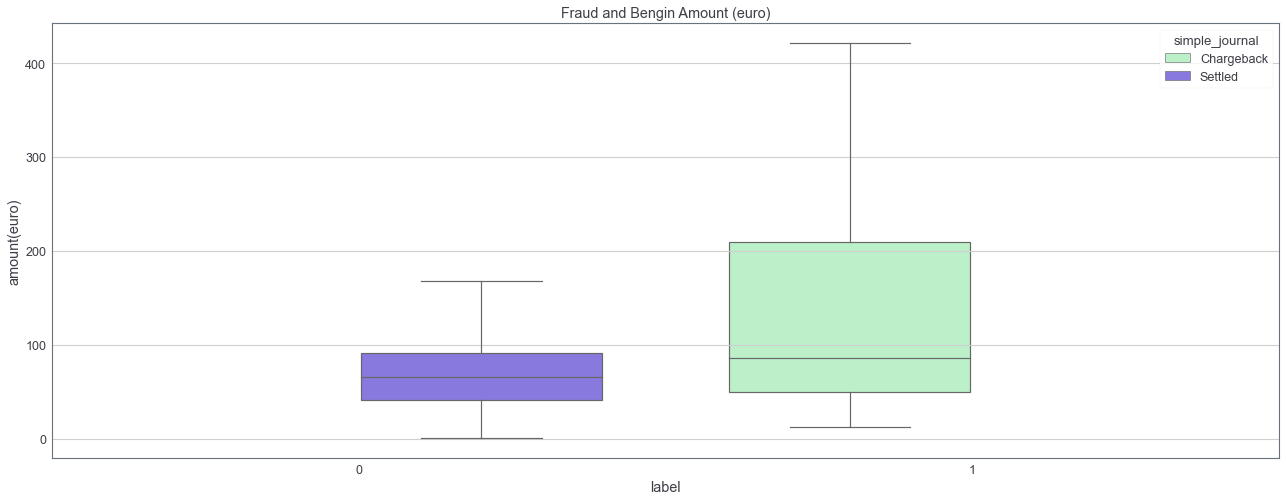

In [8]:
# setting the plot format
colors = ['#B3F9C5', '#7b68ee']
figure, (ax) = plt.subplots(1, figsize=(22, 8))
ax = sns.boxplot(x='label', y='euroAmount', hue='simple_journal', data=df_new,
                 showfliers=False, palette=colors
                 )
ax.set(xlabel='label', ylabel='amount(euro)')
plt.title('Fraud and Bengin Amount (euro)')
# plt.savefig('./figures/amountBoxplot.pdf', dpi=1200)
plt.show()

#### Histogram - txCode/issuerCountry/account/cvcRes
Histogram shows the distribution of a feature in two kinds of cases. 

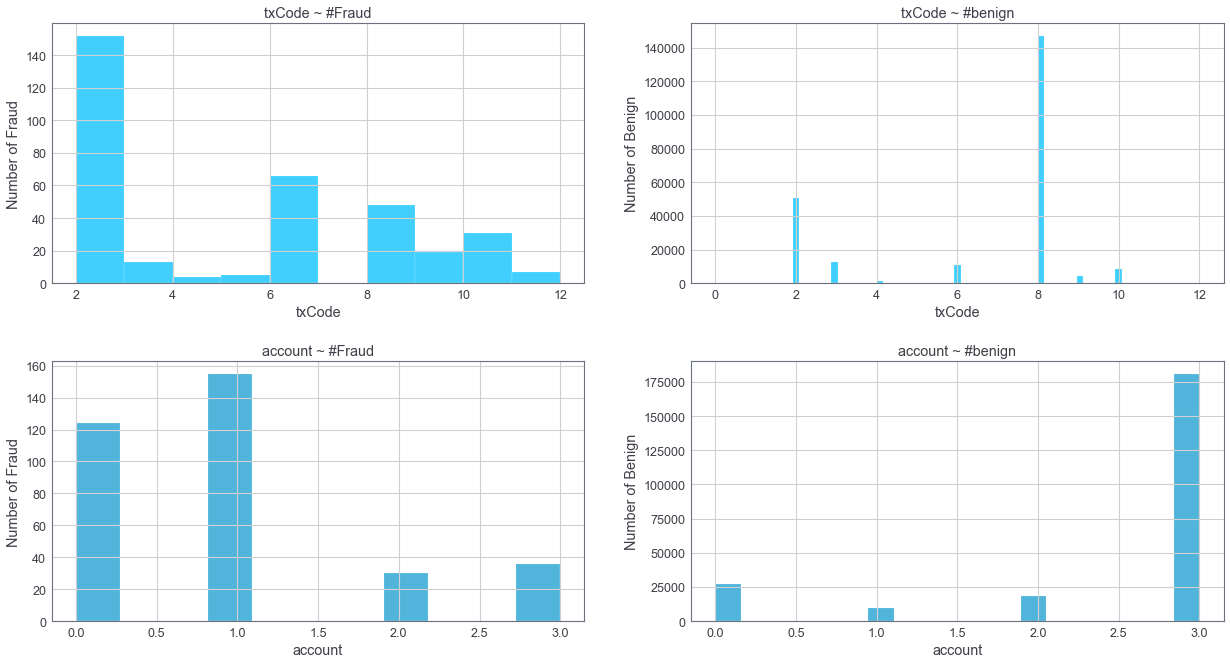

In [9]:
# setting plot format
plt.figure(figsize=(21, 11))
plt.subplots_adjust(wspace=0.2, hspace=0.3)
# histogram of txCode
plt.subplot(221)
sns.histplot(x='txCode', data=df_fraud, color='#00bfff')
plt.ylabel('Number of Fraud')
plt.title('txCode ~ #Fraud')
plt.subplot(222)
sns.histplot(x='txCode', data=df_benign, color='#00bfff')
plt.ylabel('Number of Benign')
plt.title('txCode ~ #benign')
# histogram of accountcode
plt.subplot(223)
sns.histplot(x='account', data=df_fraud, color='#179ccf')
plt.ylabel('Number of Fraud')
plt.title('account ~ #Fraud')
plt.subplot(224)
sns.histplot(x='account', data=df_benign, color='#179ccf')
plt.ylabel('Number of Benign')
plt.title('account ~ #benign')
# plt.savefig('./figures/txCode_account.pdf', dpi=1200)
plt.show()

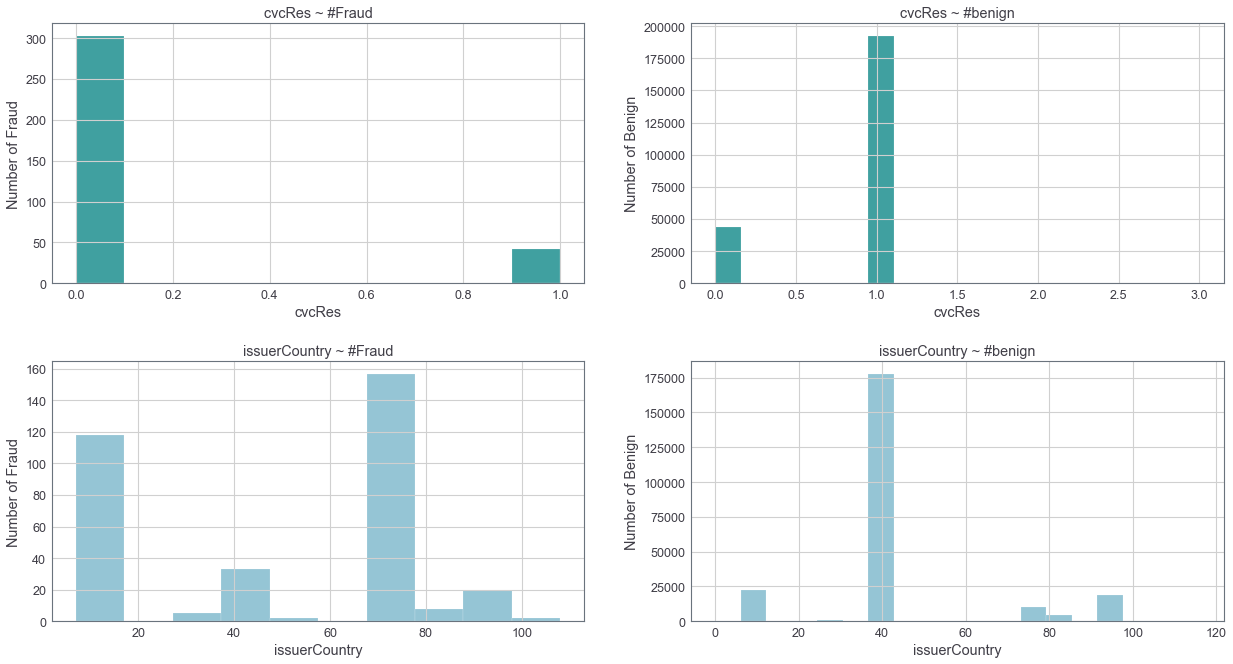

In [10]:
plt.figure(figsize=(21, 11))
plt.subplots_adjust(wspace=0.2, hspace=0.3)
# histogram of cvcresponsecode
plt.subplot(221)
sns.histplot(x='cvcRes', data=df_fraud, color='#008080')
plt.ylabel('Number of Fraud')
plt.title('cvcRes ~ #Fraud')
plt.subplot(222)
sns.histplot(x='cvcRes', data=df_benign, color='#008080')
plt.ylabel('Number of Benign')
plt.title('cvcRes ~ #benign')
# histogram of issuercountry
plt.subplot(223)
sns.histplot(x='issuerCountry', data=df_fraud, color='#72b2c7')
plt.ylabel('Number of Fraud')
plt.title('issuerCountry ~ #Fraud')
plt.subplot(224)
sns.histplot(x='issuerCountry', data=df_benign, color='#72b2c7')
plt.ylabel('Number of Benign')
plt.title('issuerCountry ~ #benign')
# plt.savefig('./figures/cvcRes_issuerCountry.pdf', dpi=1200)
plt.show()

#### Describe the visualizations and provide relavant explanations of features and relations.
1. The first figure shows that the amounts in Euro of malicious samples distribute in larger values.
2. Fraud transactions' tax codes concentrate around the value 2 when benign transactions' tax codes are mainly around 8.
3. Fraud ones happen in the accounts with 0 or 1 while benign ones tend to aggregate in the accounts with 3. 
4. The histograms of cvcresponsecode shows that the CVC response code of malicious transactions are mainly 0 while those of benign transactions are always 1. 
5. The last histogram shows that fraud mainly happens in MX, AU and GB.

## Imbalance task - Mingyu Gao
This part aims at addressing the under-sampling problem of raw data.
1. designing the smote algorithm to generate samples based on its k nearest neighbours
2. applying smoting for three classifiers - Random Forest, Gussian NB and Decision Tree
3. drawing ROC curves for smoted and unsmoted data
4. analysing their performace

In [11]:
# a dataframe copy that's used in smoting 
df_smote = df_new.copy()

In [12]:
# encoding for some uncoded features
column_list = [
 'bin',
 'shoppercountrycode',
 'cardverificationcodesupplied',
 'mail_id',
 'ip_id',
 'card_id',
 'date']
for col in column_list:
    df_smote[col] = label_encoder.fit_transform(df_smote[col].astype(str))

In [13]:
# delete uncoded features
df_smote = df_smote.drop(['txid', 'txvariantcode', 'cvcresponsecode',
 'bookingdate', 'issuercountrycode','amount', 'shopperinteraction',
 'simple_journal','creationdate', 'accountcode','currencycode'], axis ='columns')

In [14]:
df_smote.head()

,bin,shoppercountrycode,cardverificationcodesupplied,mail_id,ip_id,card_id,label,date,euroAmount,cvcRes,txCode,issuerCountry,account,interaction,shopperCountry
0,1998,98,1,97450,177775,181254,1,0,27.01512,0,2,76,1,1,98
1,2364,98,1,190289,104569,149455,1,1,18.71881,0,2,76,1,1,98
2,1965,98,1,21433,99619,25340,1,1,62.49331,0,2,76,1,1,98
3,2374,98,1,81738,187420,178315,1,35,45.81731,0,2,76,1,1,98
4,1301,98,1,176120,106944,120538,1,90,37.47931,0,6,76,1,1,98


In [15]:
# obtain the labels and features of data
df_smote_label = df_smote['label'].copy() # all labels
df_smote_temp = df_smote.copy()
df_smote_feature = df_smote_temp.drop(['label'], axis ='columns') # all features

In [16]:
# split train_set and test_set for smoting after extracting features and labels
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(
    df_smote_temp, test_size=0.2, random_state=42)
print("Number of rows in train_set " + str(len(train_set)))
print("Number of rows in test_set " + str(len(test_set)))

Number of rows in train_set 189628
Number of rows in test_set 47408


In [17]:
# split fraud and benign cases for smoting
fraud_data = train_set.loc[train_set['label'] == 1]
benign_data = train_set.loc[train_set['label'] == 0]
print("Number of rows in trainset_fraud_data " + str(len(fraud_data)))
print("Number of rows in trainset_benign_data " + str(len(benign_data)))

Number of rows in trainset_fraud_data 270
Number of rows in trainset_benign_data 189358


In [18]:
# deleting labels in fraud cases
fraud_data = fraud_data.drop(['label'], axis ='columns')

### Print ROC curves
This part we design the function of drawing ROC curves - a graphical plot that illustrates the diagnostic ability of a binary classifier.

In [19]:
# function for drawing ROC
from sklearn.metrics import roc_curve, roc_auc_score
def return_roc(model, x_train, y_train, x_test, y_test, normalize=True):
    # train set for training models
    model.fit(x_train, y_train)
    probs = model.predict_proba(x_test)[:, 1]
    auc = roc_auc_score(y_test, probs)
    fpr, tpr, _ = roc_curve(y_test, probs)    
    return fpr, tpr, auc

In [20]:
# building smote
from sklearn.neighbors import NearestNeighbors
import random
def smote(minority_for_smoting, k):
    '''
    minority_for_smoting: pandas dataframe
    k: the sampling rate
    
    return: smoted dataframe 
    '''
# k - sampling rate
    # T - Number of minority class samples
    T = len(minority_for_smoting)
    # cols - Column number of minority class samples
    n_features = len(minority_for_smoting.columns)
    # find the nearest k + 1 neighbours
    # number of neighbours > sampling rate
    nbrs = NearestNeighbors(n_neighbors = k+1, algorithm = 'auto').fit(minority_for_smoting)
    # distance : Array representing the lengths to points
    # indices: Indices of the nearest points in the population matrix
    distances, indices = nbrs.kneighbors(minority_for_smoting)
    nnarray = []
    data_array = [i for i in range(0,T * k)]
    # generating a matric for storing synthetic samples
    synthetic = pd.DataFrame(np.nan, index = data_array, columns = minority_for_smoting.columns)
    n = 0
    for i in range(len(indices)):
        # nnarray: storing the k+1 nearest neighbours
        for index in indices[i]:
            if index != i:
                nnarray.append(index)
        # choose a neighbour from the nearest k neighbours
        for k in nnarray:
            for m in range(0,n_features):
                # calculating the difference between the sample[k] to its neighbour [i]
                diff = np.subtract(minority_for_smoting.iloc[k, m], minority_for_smoting.iloc[i, m], dtype = np.float32)               
                # generating a new sample
                gap = random.uniform(0,1)
                synthetic.iloc[n, m] = minority_for_smoting.iloc[i, m] + (gap * diff)
            n += 1
        nnarray = []   
    smoted_data = minority_for_smoting.append(synthetic, ignore_index = True)    
    return smoted_data

In [21]:
# implement smote by ourselves to enlarge the fraud cases five times
smoted_fraud = smote(fraud_data,5)
print(str(len(smoted_fraud))) # check the new fraud cases

1620


In [22]:
# add labels to the smoted fraud cases
smoted_fraud["label"] = np.ones(len(smoted_fraud)) # add labels for the smoted ones
smoted_fraud.head() 

,bin,shoppercountrycode,cardverificationcodesupplied,mail_id,ip_id,card_id,date,euroAmount,cvcRes,txCode,issuerCountry,account,interaction,shopperCountry,label
0,1965.0,98.0,1.0,137758.0,95600.0,44842.0,3.0,83.33831,0.0,2.0,76.0,1.0,1.0,98.0,1.0
1,1052.0,8.0,1.0,43932.0,98051.0,32184.0,14.0,246.96595,0.0,10.0,7.0,0.0,1.0,8.0,1.0
2,2032.0,8.0,1.0,59789.0,138965.0,38182.0,59.0,218.09980,0.0,2.0,7.0,0.0,1.0,8.0,1.0
3,1504.0,8.0,1.0,22478.0,90256.0,138773.0,82.0,279.03945,0.0,6.0,7.0,0.0,1.0,8.0,1.0
4,940.0,47.0,1.0,132251.0,1434.0,143579.0,19.0,36.72333,1.0,8.0,40.0,3.0,1.0,47.0,1.0


In [23]:
# merge smoted fraud cases and benign cases
frames = [smoted_fraud, benign_data]
smoted_trainset = pd.concat(frames, sort=False)
print("length of merged: " + str(len(smoted_trainset)))

length of merged: 190978


In [24]:
# spliting labels and features for the following three classfier
smoted_labels = smoted_trainset['label'].copy()
smoted_features = smoted_trainset.drop(['label'], axis ='columns')

### classifier
To see the effect of smoting, we apply three binary classifers for test set.

In [25]:
# spliting x and y axis for trainset and testset for classifier
x_train_set, x_test_set, y_train_set, y_test_set = train_test_split(df_smote_feature, df_smote_label, test_size=0.2, random_state=42)

In [26]:
# 1. Random Forest
from sklearn.ensemble import RandomForestClassifier
## constructing Random Forest classifier
clf1 = RandomForestClassifier(n_estimators= 200, max_depth=10) 

Unsmoted AUC = 0.9527829069218797 Smoted AUC = 0.9471954027845266


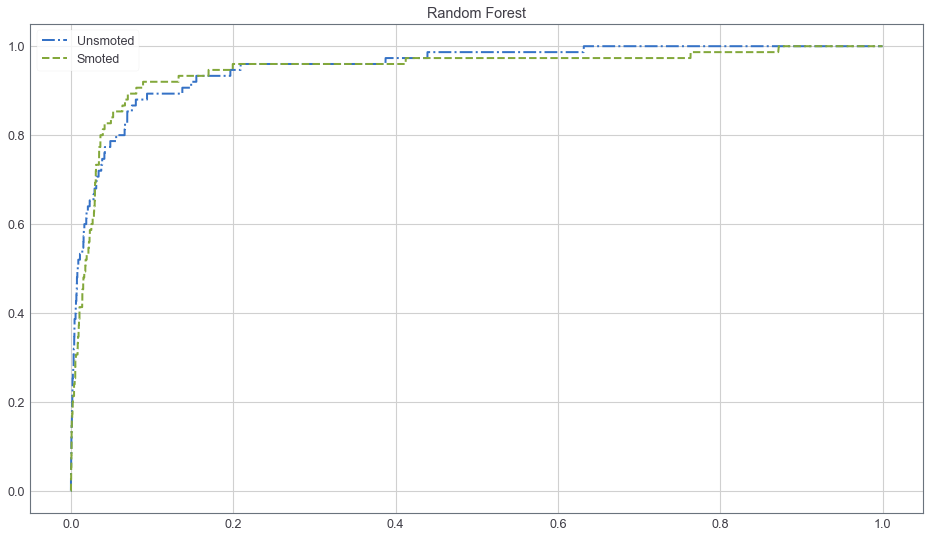

In [27]:
## plot format
plt.figure(figsize = (16,9))
## get fpr, tpr and auc values of models trained by unsmoted data
unsmoted_fpr, unsmoted_tpr, unsmoted_auc = return_roc(clf1, x_train_set, y_train_set, x_test_set, y_test_set)
plt.plot(unsmoted_fpr, unsmoted_tpr,"-.", label='Unsmoted', linewidth=2)
## get fpr, tpr and auc values of models trained by smoted data
smoted_fpr, smoted_tpr, smoted_auc = return_roc(clf1, smoted_features, smoted_labels, x_test_set, y_test_set)
## drawing the ROC curves of results of models trained by unsmoted and smoted trainset
plt.plot(smoted_fpr, smoted_tpr,"--", label='Smoted', linewidth=2)
## print the AUC values of results of models trained by unsmoted and smoted trainset
print("Unsmoted AUC =", unsmoted_auc, "Smoted AUC =", smoted_auc)
plt.legend(['Unsmoted', 'Smoted'])
plt.title("Random Forest")
plt.show()

In [28]:
# 2. Gussian NB
from sklearn.naive_bayes import GaussianNB
## constructing classifier
clf2 = GaussianNB()

Unsmoted AUC = 0.8404621159303939 Smoted AUC = 0.8451965154684188


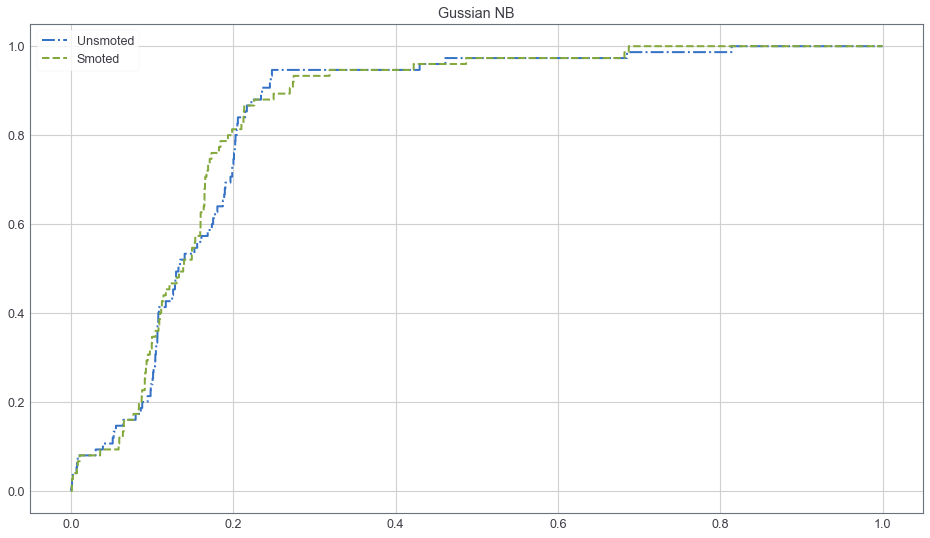

In [29]:
plt.figure(figsize = (16,9))
## get fpr, tpr and auc values of models trained by unsmoted data
unsmoted_fpr, unsmoted_tpr, unsmoted_auc = return_roc(clf2, x_train_set, y_train_set, x_test_set, y_test_set)
plt.plot(unsmoted_fpr, unsmoted_tpr,"-.", label='Unsmoted', linewidth=2)
## get fpr, tpr and auc values of models trained by smoted data
smoted_fpr, smoted_tpr, smoted_auc = return_roc(clf2, smoted_features, smoted_labels, x_test_set, y_test_set)
## drawing the ROC curves of results of models trained by unsmoted and smoted trainset
plt.plot(smoted_fpr, smoted_tpr,"--", label='Smoted', linewidth=2)
## print the AUC values of results of models trained by unsmoted and smoted trainset
print("Unsmoted AUC =", unsmoted_auc, "Smoted AUC =", smoted_auc)
plt.legend(['Unsmoted', 'Smoted'])
plt.title("Gussian NB")
plt.show()

In [30]:
# 3. Decision Tree
from sklearn import tree
clf3 = tree.DecisionTreeClassifier(splitter='random', max_depth = 10)

Unsmoted AUC = 0.8365515250107396 Smoted AUC = 0.905064401861985


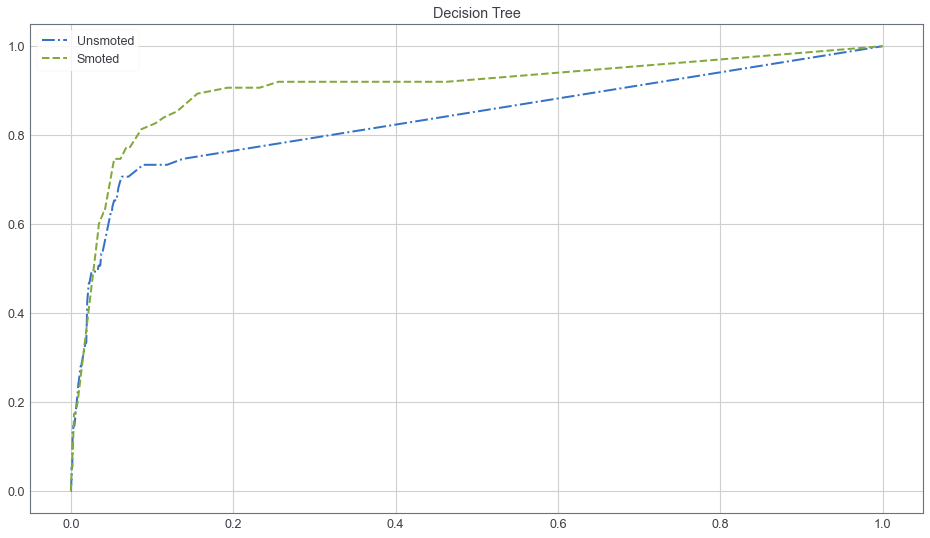

In [31]:
plt.figure(figsize = (16,9))
## get fpr, tpr and auc values of models trained by unsmoted data
unsmoted_fpr, unsmoted_tpr, unsmoted_auc = return_roc(clf3, x_train_set, y_train_set, x_test_set, y_test_set)
plt.plot(unsmoted_fpr, unsmoted_tpr,"-.", label='Unsmoted', linewidth=2)
## get fpr, tpr and auc values of models trained by smoted data
smoted_fpr, smoted_tpr, smoted_auc = return_roc(clf3, smoted_features, smoted_labels, x_test_set, y_test_set)
## drawing the ROC curves of results of models trained by unsmoted and smoted trainset
plt.plot(smoted_fpr, smoted_tpr,"--", label='Smoted', linewidth=2)
## print the AUC values of results of models trained by unsmoted and smoted trainset
print("Unsmoted AUC =", unsmoted_auc, "Smoted AUC =", smoted_auc)
plt.legend(['Unsmoted', 'Smoted'])
plt.title("Decision Tree")
plt.show()

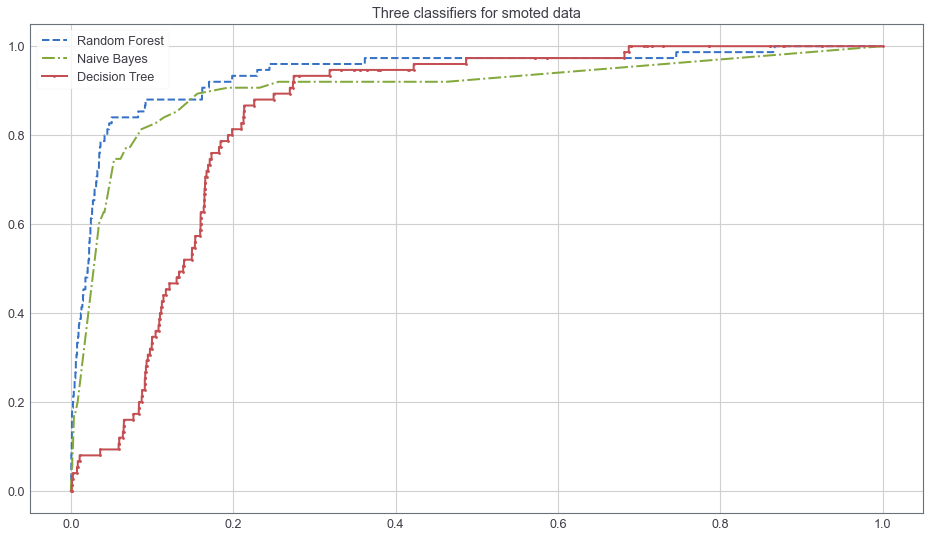

In [32]:
# draw three ROC curves of models trained by smoted trainset in one plot
plt.figure(figsize = (16,9))
smoted_fpr1, smoted_tpr1, smoted_auc1 = return_roc(clf1, smoted_features, smoted_labels, x_test_set, y_test_set)
plt.plot(smoted_fpr1, smoted_tpr1,"--", label='Random Forest', linewidth=2)

smoted_fpr2, smoted_tpr2, smoted_auc2 = return_roc(clf2, smoted_features, smoted_labels, x_test_set, y_test_set)
plt.plot(smoted_fpr, smoted_tpr,"-.", label='Naive Bayes', linewidth=2)

smoted_fpr3, smoted_tpr3, smoted_auc3 = return_roc(clf2, smoted_features, smoted_labels, x_test_set, y_test_set)
plt.plot(smoted_fpr3, smoted_tpr3,".-", label='Decision Tree', linewidth=2)
plt.legend(['Random Forest', 'Naive Bayes', 'Decision Tree'])
plt.title("Three classifiers for smoted data")
plt.show()

### Analyse the performance of the classifiers. Explain which method performs best.

The accurate of a classifier can be reflected by the area composed by the ROC curve and x-axis. Based on the three ROC curves of smoted data, we can see that Random Forest classifier performs best among the three classifies. 

### Is using SMOTE a good idea? Why (not)?

Yes. 
Considering that AUC values increas when using smoted data for all the 3 classifiers used above and the increased area of smoted ROC curve when applying decision tree, we can say that smoting data before applying classifiers gives a better dataset to work with. 

## Privacy task - Yuhang Tian
This individual task includes following:
1. Defining rank swapping function for identifying(numerical) data. 
2. Apply rank swapping on four features - 'bin', 'mail_id', 'ip_id', 'card_id'.
3. Apply rank swapping on smoted data for three classifiers - Decision Tree, Random Forest and Gaussian NB
4. Ploting ROC curves for smoted and unsmoted data
5. Analyzing their performace

### Print ROC curves
This tasks uses the same print-ROC function as imbalance task.

#### Useful Columns Extraction

In [33]:
# selecting corresponding columns for rank swapping
df_trial = df_new[[
    'date', 'issuerCountry', 
    'shopperCountry', 'interaction', 'euroAmount', 'cardverificationcodesupplied', 'cvcRes', 
    'mail_id', 'ip_id', 'card_id', 'bin','txCode', 'account', 'label'
    ]].copy()

#### NAN Modification
The first step of data preprocessing is to change the NAN value in some features.

In [34]:
df_trial.loc[df_trial['cardverificationcodesupplied'].isna(),'cardverificationcodesupplied'] = False
df_trial.loc[df_trial['issuerCountry'].isna(),'issuerCountry'] = 'ZZ'
df_trial.loc[df_trial['shopperCountry'].isna(),'shopperCountry'] = 'ZZ'
print(np.where(df_trial.isna())[1]) #no NAN anymore

[]


#### Data Spliting
The second step of data preprocessing is to select related features for rank swapping.

In [35]:
df_label = df_trial['label']
df_sample = df_trial[[
    'date', 'issuerCountry', 
    'shopperCountry', 'interaction', 'euroAmount', 'cardverificationcodesupplied', 'cvcRes', 
    'mail_id', 'ip_id', 'card_id', 'bin','txCode', 'account'
    ]]

x_train, x_test, y_train, y_test = train_test_split(df_sample, df_label, test_size=0.20, shuffle=True, random_state=42)

#### Resample
The third step of data preprocessing is to use smote to tackle with the imbalance task.

In [36]:
# Here we use the smote function in library imblearn.
def smote(X,y):
    sm = SMOTE(random_state=42)
    X_res, y_res = sm.fit_resample(X, y)
    return X_res, y_res

In [37]:
# Implementing smote for train set before swap ranking.
x_train_unswapped, y_train_unswapped = smote(x_train, y_train)
print("After SMOTE:", np.unique(y_train_unswapped, return_counts=True))

After SMOTE: (array([0, 1], dtype=int64), array([189358, 189358], dtype=int64))


#### Rank Swapping
The rank swapping alogrithm will be applied to:
- bin: card issuer identifier
- mail_id: Email address
- ip_id: Ip address
- card_id: Card number

##### Implement the rank swapping algorithm.

In [38]:
def rank_swapping(df, columns, p=1):
    '''
    df: pandas dataframe
    columns: the string names of columns
    p: the swapping range p%
    replace: replace the original dataframe
    
    return: rank swapped dataframe 
    '''
    if p == 0:
        return df
    
    print("It will take "+str(p)+" neighbour(s) into consideration")
    print(str(columns) + " - Swapping Range:", str(np.round(100*p/len(df),4))+'%')
    
    df_ = df.copy()
    length = len(df_)
    
    for column in columns:
        df_.sort_values(by=column, inplace=True)
        df_.reset_index(drop=True, inplace=True)
        col_values = df_[column].copy()
        for current_index in range(0, length):
            swap_index = current_index + random.randint(-p,p)
            if swap_index > length - 1:
                swap_index = random.randint(current_index, length-1)
            elif swap_index < 0:
                swap_index = random.randint(0, current_index)
            df_.at[current_index, column], df_.at[swap_index, column] = col_values[swap_index], col_values[current_index]
            
    return df_

##### Apply rank swapping algorithm

In [39]:
# check the content of unswapped pd
x_train_unswapped.head()

,date,issuerCountry,shopperCountry,interaction,euroAmount,cardverificationcodesupplied,cvcRes,mail_id,ip_id,card_id,bin,txCode,account
0,91,7,8,1,102.63520,1,0,123705,31114,160263,401795.0,8,0
1,47,96,122,1,117.32210,1,1,2173,89498,30314,453903.0,8,2
2,18,40,47,1,36.72333,1,1,204188,204483,192658,475117.0,8,3
3,38,40,47,1,51.72300,1,1,58864,136516,195673,475117.0,8,3
4,106,40,47,1,32.12573,1,1,132837,5577,8567,492181.0,8,3


In [40]:
# copy the pd of unswapped train set
x_train_swapped, y_train_swapped = x_train_unswapped.copy(), y_train_unswapped.copy()
# copy the label of trainset
x_train_swapped['temp_label'] = y_train_swapped.copy()
# apply rank swapping on four features 
x_train_swapped = rank_swapping(x_train_swapped, ['bin', 'mail_id', 'ip_id', 'card_id'], p=100)
# obtain the labels of swapped train set
y_train_swapped = x_train_swapped['temp_label'].copy()
# obtain the features of swapped train set
x_train_swapped.drop(columns=['temp_label'], inplace=True)

It will take 100 neighbour(s) into consideration
['bin', 'mail_id', 'ip_id', 'card_id'] - Swapping Range: 0.0264%


In [41]:
x_train_unswapped.head()

,date,issuerCountry,shopperCountry,interaction,euroAmount,cardverificationcodesupplied,cvcRes,mail_id,ip_id,card_id,bin,txCode,account
0,91,7,8,1,102.63520,1,0,123705,31114,160263,401795.0,8,0
1,47,96,122,1,117.32210,1,1,2173,89498,30314,453903.0,8,2
2,18,40,47,1,36.72333,1,1,204188,204483,192658,475117.0,8,3
3,38,40,47,1,51.72300,1,1,58864,136516,195673,475117.0,8,3
4,106,40,47,1,32.12573,1,1,132837,5577,8567,492181.0,8,3


In [42]:
x_train_swapped.head()

,date,issuerCountry,shopperCountry,interaction,euroAmount,cardverificationcodesupplied,cvcRes,mail_id,ip_id,card_id,bin,txCode,account
0,99,40,47,1,50.228780,0,1,148781,174940,66,465859.000000,8,3
1,107,40,47,1,92.722098,1,1,122004,11379,47,527727.030708,2,3
2,7,40,47,1,88.216450,1,1,16603,198541,1,475129.000000,8,3
3,105,40,47,1,99.066786,1,1,120722,40580,106,465901.000000,8,3
4,18,40,47,1,62.010130,1,1,204585,11650,35,465855.000000,8,3


##### Train three classifiers using rank swapping/unswapping
By separately applying unswap and swapped train set on three classifiers, we can see the effect of rank swapping algorithm based on the results of test set.

In [43]:
# function for drawing ROC curves
def return_roc(model, x_train, y_train, x_test, y_test, normalize=True):
    # add 
    if (normalize):
        scaler_norm = Normalizer().fit(x_train)
        x_train = scaler_norm.transform(x_train)
        x_test = scaler_norm.transform(x_test)
    
    model.fit(x_train, y_train)
    probs = model.predict_proba(x_test)[:, 1]
    auc = roc_auc_score(y_test, probs)
    fpr, tpr, _ = roc_curve(y_test, probs)    
    
    return fpr, tpr, auc

###### Decision Tree

Unswapped AUC = 0.8862838470693455 Swapped AUC = 0.8090234438270691


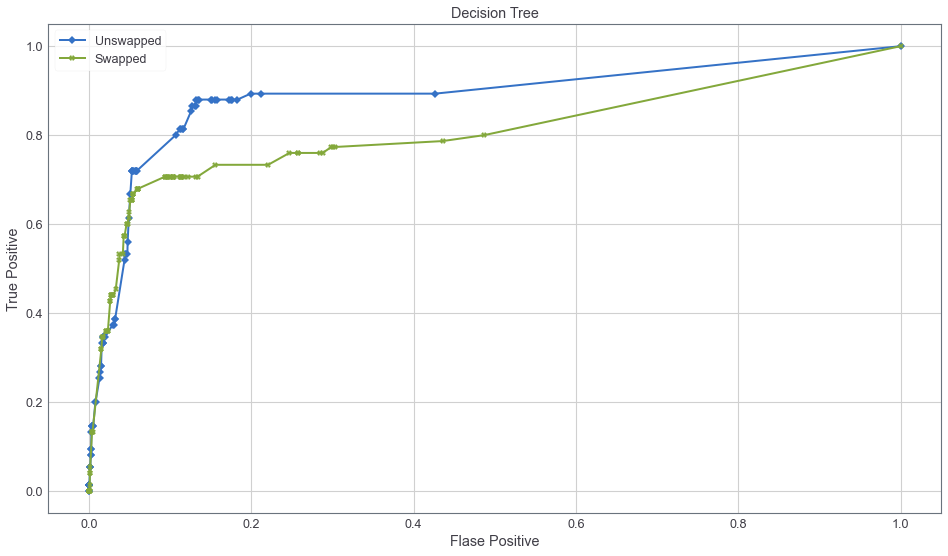

In [44]:
# constructing decision tree classifier
dt = DecisionTreeClassifier(splitter='random', max_depth=10)
plt.figure(figsize=(16,9))
# drawing ROC curve for test set result of decision tree classifier trained by unswapped train set
unswapped_fpr, unswapped_tpr, unswapped_auc = return_roc(dt, x_train_unswapped, y_train_unswapped, x_test, y_test)
plt.plot(unswapped_fpr, unswapped_tpr, "-D", label='Unswapped', linewidth=2)
# drawing ROC curve for test set result of decision tree classifier trained by swapped train set
swapped_fpr, swapped_tpr, swapped_auc = return_roc(dt, x_train_swapped, y_train_swapped, x_test, y_test)
plt.plot(swapped_fpr, swapped_tpr, "-X", label='Swapped', linewidth=2)
print("Unswapped AUC =", unswapped_auc, "Swapped AUC =", swapped_auc)
plt.xlabel('Flase Positive')
plt.ylabel('True Positive')
plt.legend(['Unswapped', 'Swapped'])
plt.title("Decision Tree")
plt.show()

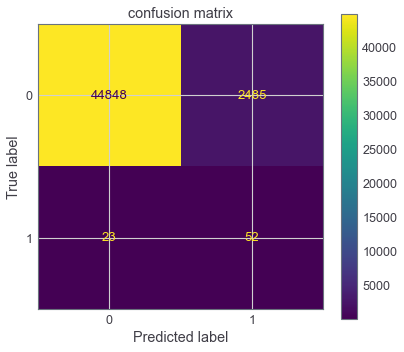

In [45]:
# plotting confusion matrix 
dt.fit(x_train_unswapped, y_train_unswapped)
plot_confusion_matrix(dt, x_test, y_test)
plt.title('confusion matrix')
plt.show()

###### Random Forest

Unswapped AUC = 0.9191187261882127 Swapped AUC = 0.9205912717695195


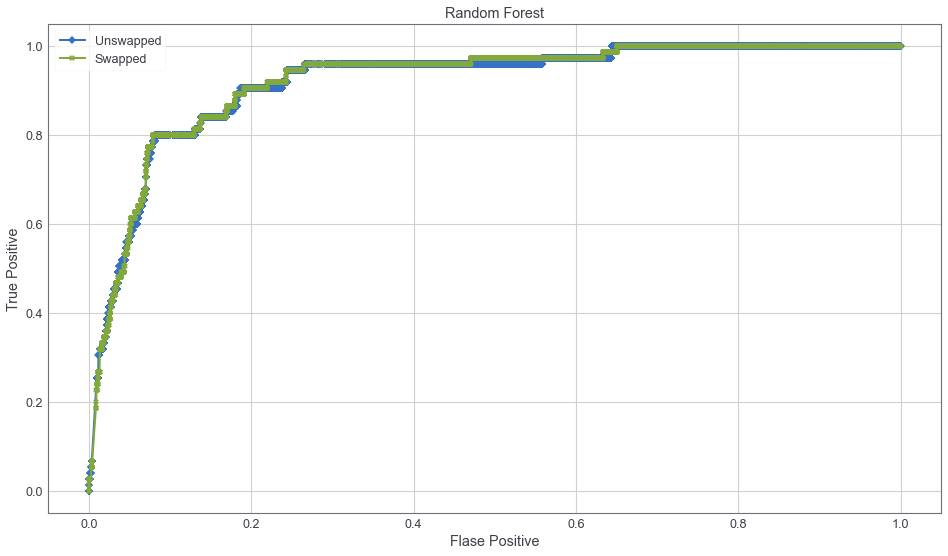

In [46]:
# constructing random forest classifier
rf = RandomForestClassifier(n_estimators=200, max_depth=3)
plt.figure(figsize=(16,9))
# drawing ROC curve for test set result of random forest classifier trained by unswapped train set
unswapped_fpr, unswapped_tpr, unswapped_auc = return_roc(rf, x_train_unswapped, y_train_unswapped, x_test, y_test, normalize=False)
plt.plot(unswapped_fpr, unswapped_tpr, "-D", label='Unswapped', linewidth=2)
# drawing ROC curve for test set result of random forest classifier trained by swapped train set
swapped_fpr, swapped_tpr, swapped_auc = return_roc(rf, x_train_swapped, y_train_swapped, x_test, y_test, normalize=False)
plt.plot(swapped_fpr, swapped_tpr, "-X", label='Swapped', linewidth=2)
print("Unswapped AUC =", unswapped_auc, "Swapped AUC =", swapped_auc)
plt.xlabel('Flase Positive')
plt.ylabel('True Positive')
plt.legend(['Unswapped', 'Swapped'])
plt.title("Random Forest")
plt.show()

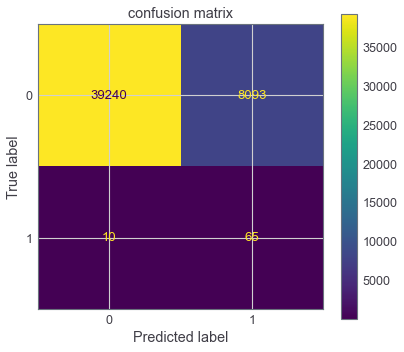

In [47]:
# plotting confusion matrix 
rf.fit(x_train_unswapped, y_train_unswapped)
plot_confusion_matrix(rf, x_test, y_test)
plt.title('confusion matrix')
plt.show()

######  GaussianNB

Unswapped AUC = 0.8433511503602139 Swapped AUC = 0.8433387559067318


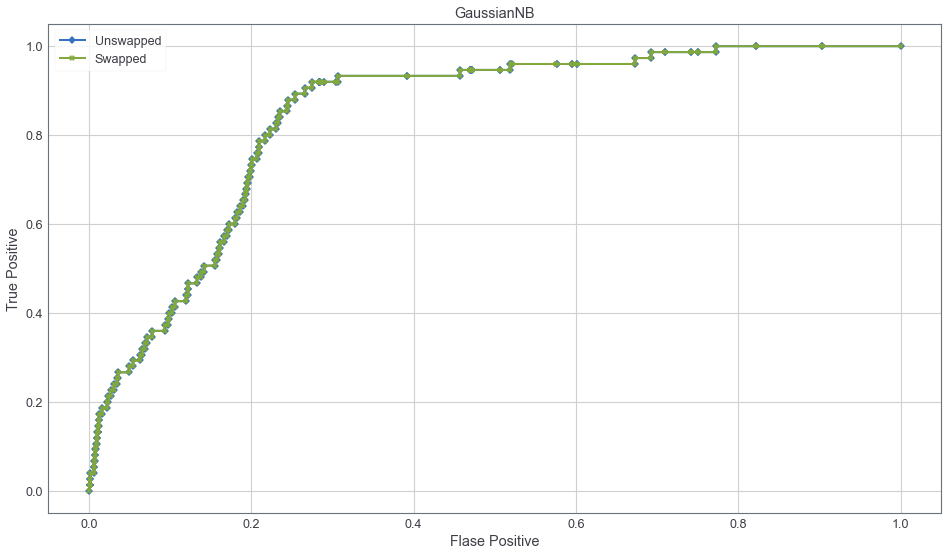

In [48]:
# constructing Gaussian NB classifier
nb = GaussianNB()
plt.figure(figsize=(16,9))
# drawing ROC curve for test set result of Gaussian NB classifier trained by unswapped train set
unswapped_fpr, unswapped_tpr, unswapped_auc = return_roc(nb, x_train_unswapped, y_train_unswapped, x_test, y_test)
plt.plot(unswapped_fpr, unswapped_tpr, "-D", label='Unswapped', linewidth=2)
# drawing ROC curve for test set result of Gaussian NB classifier trained by swapped train set
swapped_fpr, swapped_tpr, swapped_auc = return_roc(nb, x_train_swapped, y_train_swapped, x_test, y_test)
plt.plot(swapped_fpr, swapped_tpr, "-X", label='Swapped', linewidth=2)
print("Unswapped AUC =", unswapped_auc, "Swapped AUC =", swapped_auc)
plt.xlabel('Flase Positive')
plt.ylabel('True Positive')
plt.legend(['Unswapped', 'Swapped'])
plt.title("GaussianNB")
plt.show()

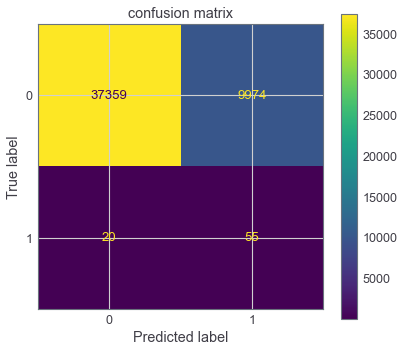

In [49]:
# plotting confusion matrix 
nb.fit(x_train_unswapped, y_train_unswapped)
plot_confusion_matrix(nb, x_test, y_test)
plt.title('confusion matrix')
plt.show()

### Analyse the performance of the classifiers. Explain which method performs best.

By comparing the ROC curves and confusion matrixes of three classifiers, we can see that Random Forest classifier performs best. It not only has the largest area composed by ROC curve but also finds the most fraud cases as shown in confusion matrix.

### Can you explain the performance difference for the different classifiers? Is it advisable to protect people’s privacy using rank-swapping? Why (not)?

No.
From ROC curves and AUC values, although we can see that classifier trained by swapped data does not perform obviously better than the classifier trained by unswapped data.
Theoretically, rank swapping aims at protecting data's privacy rather than enhance the classifying result. 


## Classification task

### Print relevant plots and metrics with clear headings.

In [50]:
# implementing k-fold cross validation function
def k_fold_validation(X, y, model, scoring='precision', k_flod=10):
    cv = KFold(n_splits=k_flod, random_state=42, shuffle=True)
    scores = cross_validate(model, X, y, scoring=scoring, return_estimator=True, cv=cv, n_jobs=-1)
    max_score_index = np.argmax(scores['test_score'])
    
    return scores['test_score'][max_score_index], scores['estimator'][max_score_index] 

#### White Box - Decision Tree
White-box classifier can explain the decision step by step.

In [51]:
# Constructng the white-box classifier: decision tree
dt = DecisionTreeClassifier(splitter='random', max_depth=10)
# Implementing k-fold cross validation before applying the classifier
dt_max_score, dt_estimator = k_fold_validation(X = x_train_unswapped, y = y_train_unswapped, model=dt)

<Figure size 1152x648 with 0 Axes>

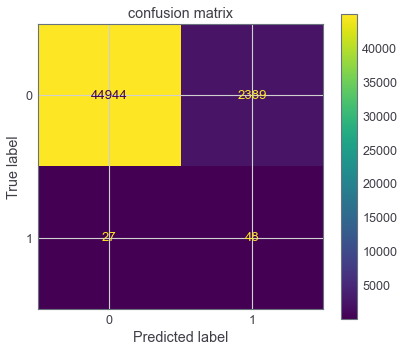

In [52]:
# Ploting confusion matrix of classifier's results
plt.figure(figsize=(16,9))
plot_confusion_matrix(dt_estimator, x_test, y_test)
plt.title('confusion matrix')
plt.show()

In [53]:
# select the the fraud cases in test set
x_test_fraud = x_test.iloc[np.where(y_test==1)[0], :]
y_pred = dt_estimator.predict(x_test_fraud)

In [54]:
# select the true positive results in fraud cases
x_test_TP = x_test_fraud.iloc[np.where(y_pred==1)[0], :]
# select the false positive results in fraud cases
x_test_FP = x_test_fraud.iloc[np.where(y_pred==0)[0], :]

In [55]:
x_test_TP[:]

,date,issuerCountry,shopperCountry,interaction,euroAmount,cardverificationcodesupplied,cvcRes,mail_id,ip_id,card_id,bin,txCode,account
27986,90,7,8,1,208.477750,True,0,157424,10325,207556,456468.0,10,0
27969,72,7,8,1,279.039450,True,0,163524,103359,205062,423953.0,8,0
117,101,76,98,1,72.874120,True,0,8077,7222,192188,493158.0,10,1
129,108,76,98,1,54.155310,True,0,196132,196616,70073,549138.0,2,1
119,103,76,98,1,24.888930,True,0,101992,6769,51488,477291.0,6,1
33,30,76,98,1,34.977910,True,0,19627,187822,165746,520416.0,2,1
70,58,76,98,1,58.324310,True,0,199232,194664,192722,477213.0,9,1
120,103,76,98,1,37.437620,True,0,81794,196469,22516,547046.0,2,1
151,122,76,98,1,275.070620,True,0,178870,188470,169925,410180.0,6,1
128,107,76,98,1,283.408620,True,0,25008,195764,130802,548234.0,2,1


In [56]:
x_test_FP[:]

,date,issuerCountry,shopperCountry,interaction,euroAmount,cardverificationcodesupplied,cvcRes,mail_id,ip_id,card_id,bin,txCode,account
58660,114,40,47,1,127.008700,True,1,44453,19721,76863,492910.0,10,3
27993,93,7,8,1,346.393800,True,0,69591,20049,156595,535316.0,2,0
58648,67,40,47,1,82.699330,True,1,180818,75614,75745,492910.0,10,3
27975,83,7,8,1,128.294000,True,0,114052,39284,210501,414726.0,12,0
12,16,76,98,1,49.986310,True,0,203705,193306,142105,493173.0,9,1
27944,47,7,8,1,69.599495,True,0,167282,169950,140586,456469.0,10,0
58645,41,40,47,1,49.711550,True,1,62297,157746,203787,484431.0,8,3
28004,101,7,8,1,577.323000,True,0,175640,10028,123754,456471.0,6,0
27970,73,7,8,1,240.551250,True,0,92585,30484,109664,460184.0,12,0
34,30,76,98,1,33.310310,True,0,203458,193431,200769,477214.0,10,1


In [57]:
# Plotting the pie chart of TP and FP results to analyze the process of classifier

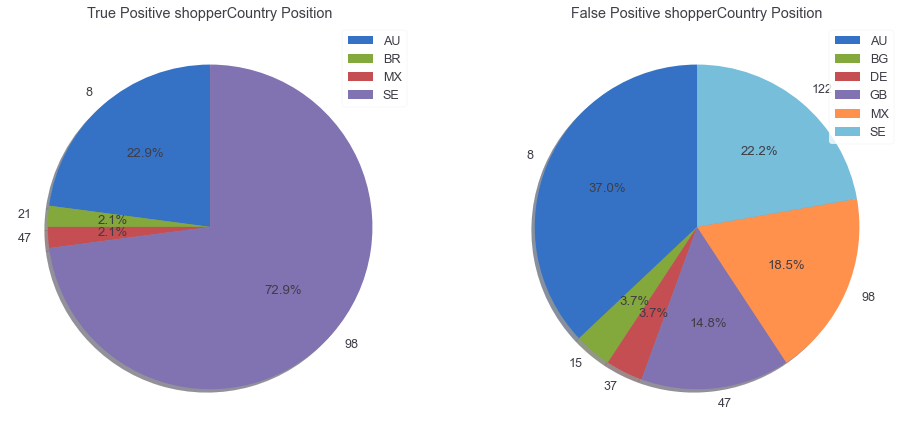

In [58]:
# Ploting pie chart of feature - 'shopperCountry' in TP and FP results separately
pie_TP_params = np.unique(x_test_TP['shopperCountry'], return_counts=True)
pie_FP_params = np.unique(x_test_FP['shopperCountry'], return_counts=True)
# Setting plot format
plt.figure(figsize=(16,9))
plt.subplot(121)
plt.pie(x=pie_TP_params[1], labels=pie_TP_params[0],
        autopct='%1.1f%%',shadow=True, startangle=90)
plt.legend(['AU', 'BR', 'MX', 'SE'])
plt.title('True Positive shopperCountry Position')
plt.subplot(122)
plt.pie(x=pie_FP_params[1], labels=pie_FP_params[0],
        autopct='%1.1f%%',shadow=True, startangle=90)
plt.legend(['AU', 'BG', 'DE', 'GB', 'MX', 'SE'])
plt.title('False Positive shopperCountry Position')
# plt.savefig("./figures/pie_shopperCountry.pdf", pdi=1200)
plt.show()

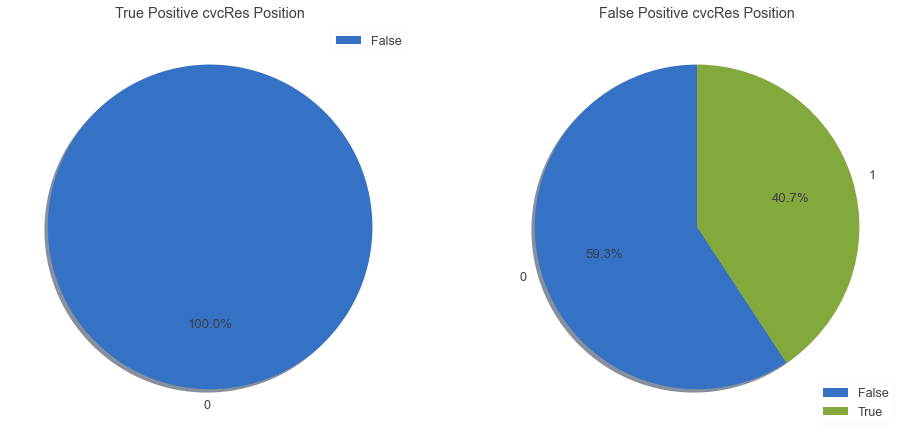

In [59]:
# Ploting pie chart of feature - 'cvcRes' in TP and FP results separately
pie_TP_params = np.unique(x_test_TP['cvcRes'], return_counts=True)
pie_FP_params = np.unique(x_test_FP['cvcRes'], return_counts=True)
# Setting plot format
plt.figure(figsize=(16,9))
plt.subplot(121)
plt.pie(x=pie_TP_params[1], labels=pie_TP_params[0],
        autopct='%1.1f%%',shadow=True, startangle=90)
plt.title('True Positive cvcRes Position')
plt.legend(['False', 'True'])
plt.subplot(122)
plt.pie(x=pie_FP_params[1], labels=pie_FP_params[0],
        autopct='%1.1f%%',shadow=True, startangle=90)
plt.title('False Positive cvcRes Position')
plt.legend(['False', 'True'])
# plt.savefig("./figures/pie_cvcRes.pdf", pdi=1200)
plt.show()

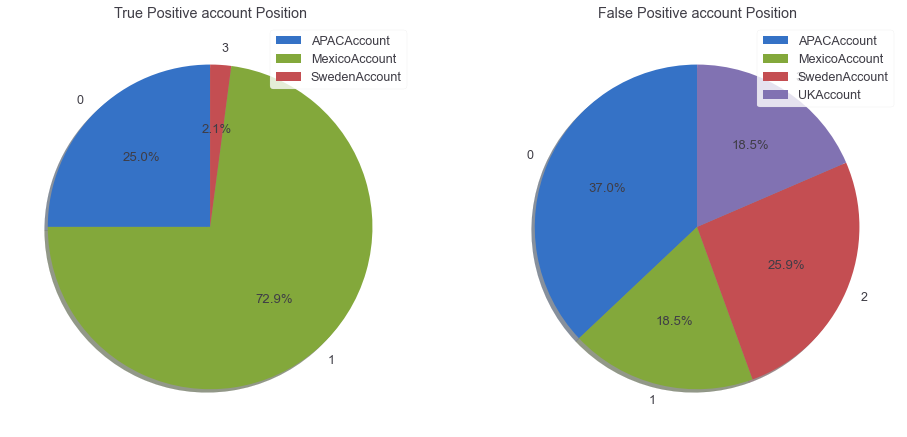

In [60]:
# Ploting pie chart of feature - 'account' in TP and FP results separately
pie_TP_params = np.unique(x_test_TP['account'], return_counts=True)
pie_FP_params = np.unique(x_test_FP['account'], return_counts=True)
# Setting plot format
plt.figure(figsize=(16,9))
plt.subplot(121)
plt.pie(x=pie_TP_params[1], labels=pie_TP_params[0],
        autopct='%1.1f%%',shadow=True, startangle=90)
plt.title('True Positive account Position')
plt.legend(['APACAccount', 'MexicoAccount', 'SwedenAccount'])
plt.subplot(122)
plt.pie(x=pie_FP_params[1], labels=pie_FP_params[0],
        autopct='%1.1f%%',shadow=True, startangle=90)
plt.title('False Positive account Position')
plt.legend(['APACAccount', 'MexicoAccount', 'SwedenAccount', 'UKAccount'])
# plt.savefig("./figures/pie_account.pdf", pdi=1200)
plt.show()

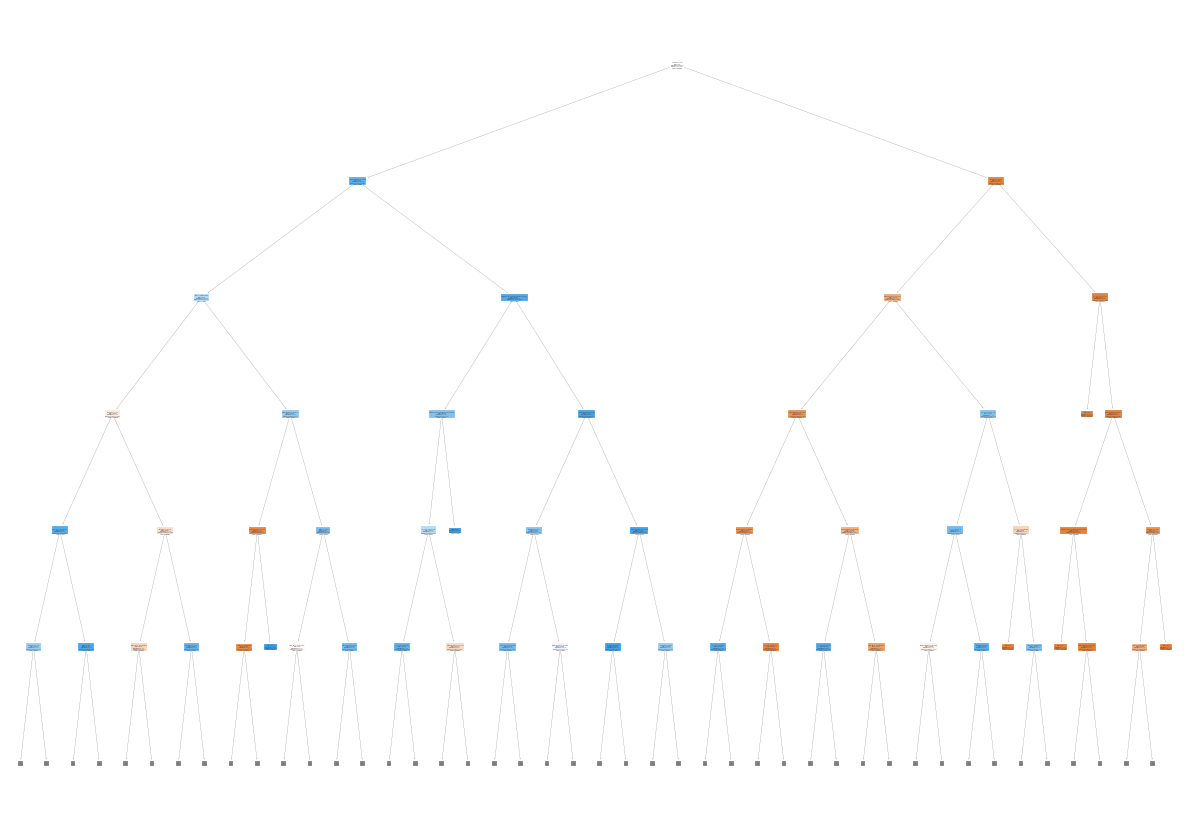

In [61]:
# Plot the first three layers of decision tree to have a brief look at its decision process
plt.figure(figsize=(21,15))
feature_names = x_train_unswapped.columns
class_names = ['benign', 'fraud']
plot_tree(dt_estimator, max_depth=5, filled=True, feature_names=feature_names, class_names=class_names, proportion=True)
# plt.savefig('./figures/Dtree.pdf', dpi=1200)
plt.show()

#### Black-box: Random Forest

In [62]:
# Constructing Random Forest Classifier
rf = RandomForestClassifier(n_estimators=200, max_depth=5)
# Implementing k-fold cross validation before applying classifier
rf_max_score, rf_estimator = k_fold_validation(X = x_train_unswapped, y = y_train_unswapped, model=rf)

<Figure size 1152x648 with 0 Axes>

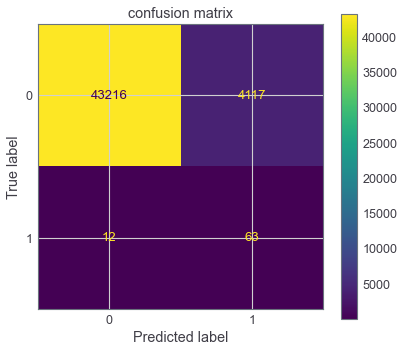

In [63]:
# Plotting confusion matrix for the black-box classifier after k-fold cross validation
plt.figure(figsize=(16,9))
plot_confusion_matrix(rf_estimator, x_test, y_test)
plt.title('confusion matrix')
plt.show()

### Explain the applied data pre-processing steps, learning algorithms, and post-processing steps or ensemble methods. 

### Compare the performance of the two algorithms, focusing on performance criteria that are relevant in practice, use 10-fold cross-validation.
Based on the confusion matrix result, black-box classifier(Random Forest) performs better than the white-box classifier(Decision Tree) as it finds more fraud cases in the same test set. 


## Bonus task

Text(0.5, 1.0, 'cvcRes ~ #Fraud')

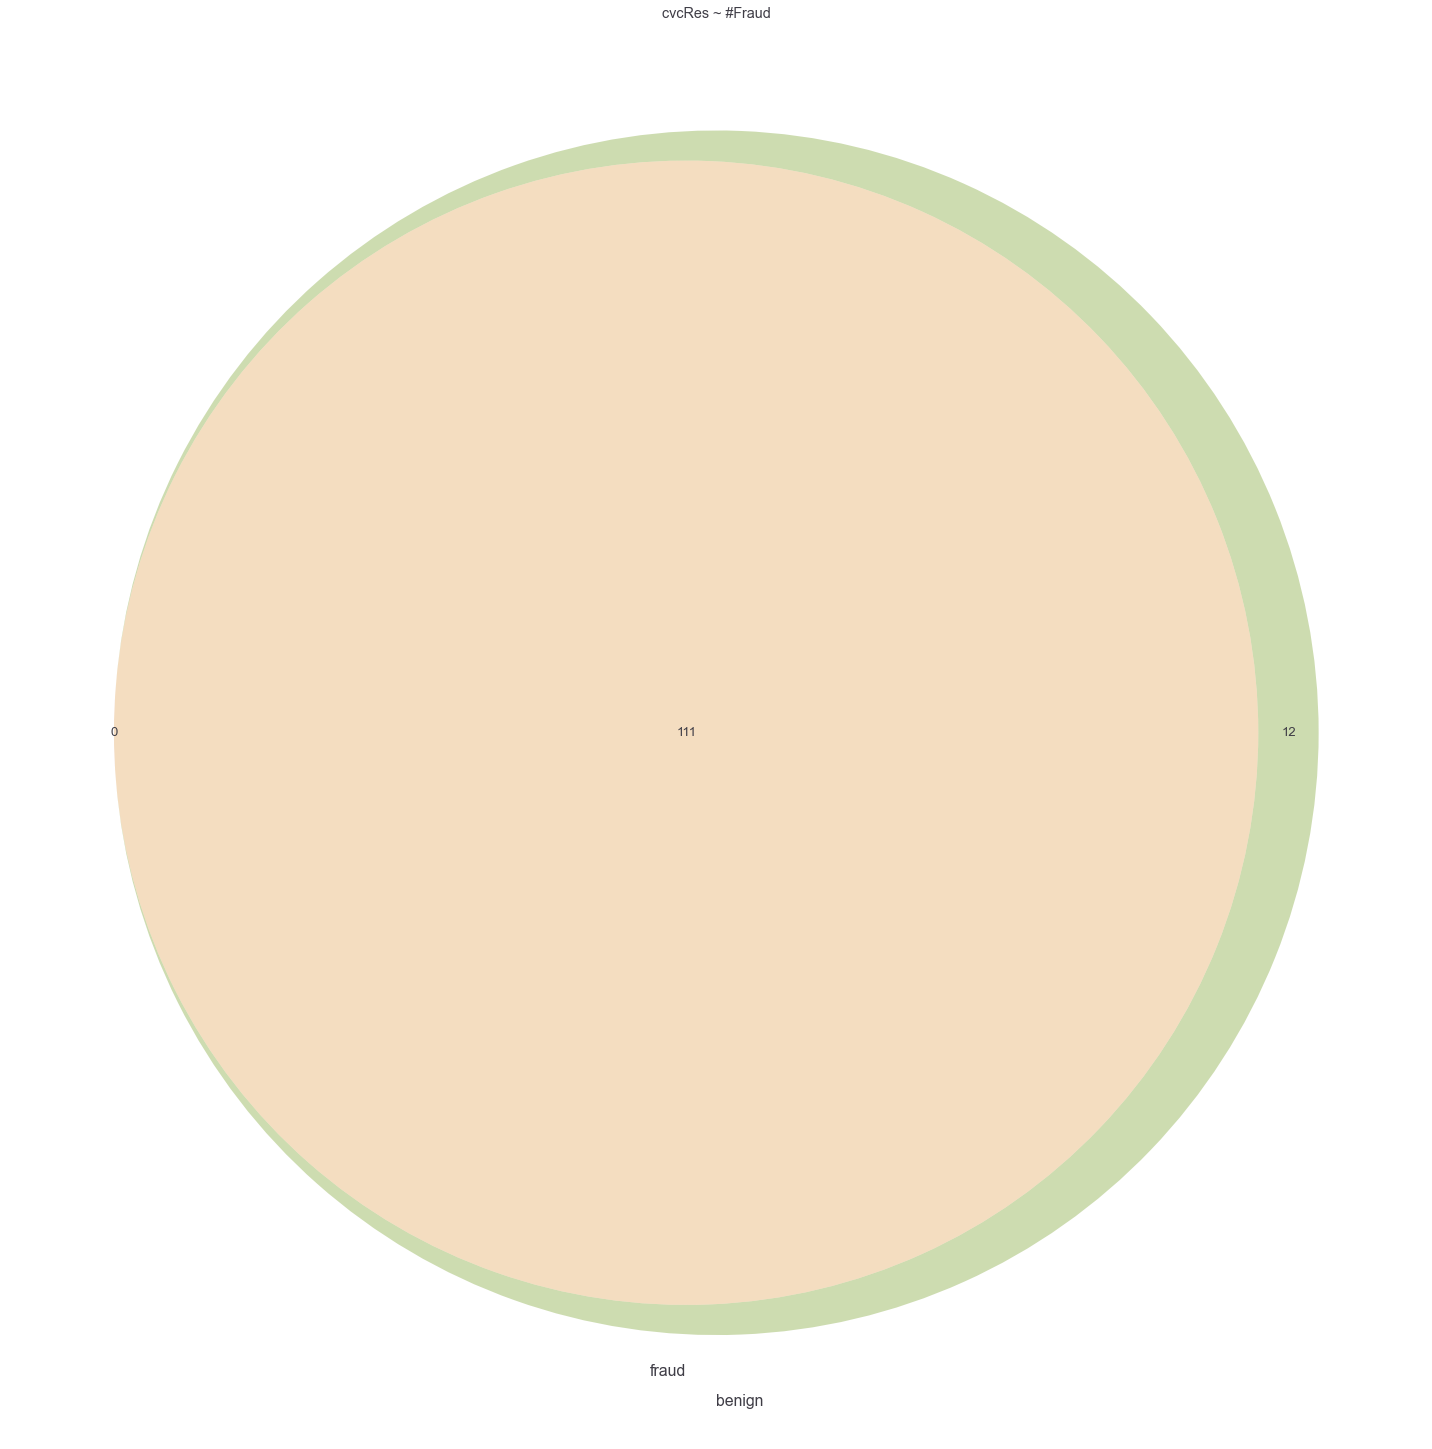

In [64]:
# plot the overlap of two dataframe
plt.figure(figsize=(60, 60))
# current our aggregate dataframe is unsomted and unswapped
df_aggregate = df_new[[
    'date', 'issuerCountry', 
    'shopperCountry', 'interaction', 'euroAmount', 'cardverificationcodesupplied', 'cvcRes', 
    'mail_id', 'ip_id', 'card_id', 'bin','txCode', 'account', 'label'
    ]].copy()
# df_aggregate = x_train_swapped
df_aggregate_fraud = df_aggregate[df_aggregate['label'] == 1]
df_aggregate_benign = df_aggregate[df_aggregate['label'] == 0]
plt.subplots_adjust(wspace=0.2, hspace=0.3)
# check the overlap
plt.subplot(221)
venn2([
    set(df_aggregate_fraud['date'].values),
    set(df_aggregate_benign['date'].values)
], set_labels=('fraud', 'benign'))
plt.ylabel('Number of Fraud')
plt.title('cvcRes ~ #Fraud')
# 

In [65]:
df_aggregate.head()

,date,issuerCountry,shopperCountry,interaction,euroAmount,cardverificationcodesupplied,cvcRes,mail_id,ip_id,card_id,bin,txCode,account,label
0,0,76,98,1,27.01512,True,0,187702,7386,73358,530056.0,2,1,1
1,1,76,98,1,18.71881,True,0,834,194109,44739,547046.0,2,1,1
2,1,76,98,1,62.49331,True,0,119287,189655,122802,528843.0,2,1,1
3,2,76,98,1,45.81731,True,0,173561,8254,70712,547146.0,2,1,1
4,7,76,98,1,37.47931,True,0,70647,196247,208481,477291.0,6,1,1


In [66]:
data_group = df_aggregate.groupby(['date'])[['euroAmount']]

In [67]:
data_group.head()

,euroAmount
0,27.01512
1,18.71881
2,62.49331
3,45.81731
4,37.47931
...,...
27867,56.23981
27868,33.31031
27869,129.15562
27870,83.33831


In [68]:
data_group_df = pd.DataFrame()
# total amount
data_group_df['amount_sum'] = data_group.sum()['euroAmount']
# how many times
data_group_df['times_of_transaction'] = data_group.count()['euroAmount']
data_group_df.reset_index(inplace=True)
data_group_df.rename(index=str, columns={'index': 'item_id'})

data_group_df.head()

,date,amount_sum,times_of_transaction
0,0,171541.047237,2369
1,1,165364.416495,2286
2,2,139952.586291,1941
3,3,139134.316036,1940
4,4,191201.577321,2558


In [69]:
# drop duplicate card id in the aggregate dataframe and merge the features back
df_aggregated = df_aggregate.copy()
df_aggregated.drop_duplicates(['date'], inplace=True)
df_aggregated = df_aggregated.merge(data_group_df, on='date', how='left')
df_aggregated.head()

,date,issuerCountry,shopperCountry,interaction,euroAmount,cardverificationcodesupplied,cvcRes,mail_id,ip_id,card_id,bin,txCode,account,label,amount_sum,times_of_transaction
0,0,76,98,1,27.01512,True,0,187702,7386,73358,530056.0,2,1,1,171541.047237,2369
1,1,76,98,1,18.71881,True,0,834,194109,44739,547046.0,2,1,1,165364.416495,2286
2,2,76,98,1,45.81731,True,0,173561,8254,70712,547146.0,2,1,1,139952.586291,1941
3,7,76,98,1,37.47931,True,0,70647,196247,208481,477291.0,6,1,1,138475.011535,1891
4,8,76,98,1,29.14131,True,0,24698,196216,130614,477291.0,6,1,1,127414.682932,1743


Text(0.5, 1.0, 'cvcRes ~ #Fraud')

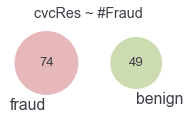

In [70]:
df_aggregated_fraud = df_aggregated[df_aggregated['label'] == 1]
df_aggregated_benign = df_aggregated[df_aggregated['label'] == 0]
plt.subplots_adjust(wspace=0.2, hspace=0.3)
# check the overlap
plt.subplot(221)
venn2([
    set(df_aggregated_fraud['date'].values),
    set(df_aggregated_benign['date'].values)
], set_labels=('fraud', 'benign'))
plt.ylabel('Number of Fraud')
plt.title('cvcRes ~ #Fraud')

In [71]:
df_aggregated = df_aggregated.sort_values(by='date')

In [81]:
# def range_data_group(arr):
#     return arr.max() - arr.min()
# df_group = df_trial.agg(range_data_group)
# df_group = df_trial.agg({'euroAmount':'mean', 'interacrion': range_data_group})

In [82]:
df_group.head()

,date,issuerCountry,shopperCountry,interaction,euroAmount,cardverificationcodesupplied,cvcRes,mail_id,ip_id,card_id,bin,txCode,account,label
0,0,76,98,1,27.01512,True,0,187702,7386,73358,530056.0,2,1,1
1,1,76,98,1,18.71881,True,0,834,194109,44739,547046.0,2,1,1
2,1,76,98,1,62.49331,True,0,119287,189655,122802,528843.0,2,1,1
3,2,76,98,1,45.81731,True,0,173561,8254,70712,547146.0,2,1,1
4,7,76,98,1,37.47931,True,0,70647,196247,208481,477291.0,6,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290377,122,96,122,1,47.42179,True,1,23852,16764,196325,453903.0,8,2,0
290378,122,96,122,1,192.25050,True,1,106775,67997,27390,554501.0,3,2,0
290379,122,96,122,1,51.75975,True,1,152970,87084,36581,453903.0,8,2,0
290380,122,96,122,1,86.46343,True,1,206916,66888,36060,554501.0,3,2,0
